## ALMA inference

The purpose of this project is to use ALMA model (write simple program to inference it through localhost web ui - no langchain, no complicated libraries, just simple webapp). 

This project could be also a way to test some solutions for web interfaces of more complicated DocWhisper project. 
Because model is not just translator, to get just translation functionality we got two options:
- hard prompting (ad hoc solution)
- disitlation of model (from decoder-only to encoder-decoder architecture)

1) we quantize model to smaller size (if X-ALMA will not be possible we could use GGUF version) - in other project we will learn how to quantize models to for example GGUF ourselves (patrz. BIBLIOTEKA_transformers-GPTs)
    - how to quatize model?
    - how to save it to for example GGUF?
2) we distill knowledge to smaller model
3) we create simple algo for inference
4) we import our custom model 

It is not worth to lower precision to int8 for pre-quantize model for now (I might look into it in a future)

In [ ]:
# Text to przetłumaczenia
# "Translate this from Polish to English:\nPolish: Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi. Jest to technika optymalizacji. Agentic Workflow z drugiej strony to wiele niezależnych modeli, które działają w ramach jakiejś aplikacji, np. jeśli dane wejściowe to obraz, działają agenci wizji komputerowej itp. Bagging trenuje kilka różnych modeli, każdy na innym zbiorze danych i uśrednia wyniki, a boosting używa kilku różnych modeli, z których każdy poprawia błędy poprzedniego. Czy to wyjaśnienie jest poprawne? \nEnglish:"

In [1]:
import torch
import pathlib
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
#from peft import PeftModel
#from transformers import pipeline
#from llama_cpp import Llama
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import json
import pdfplumber

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
cache_dir = pathlib.Path.cwd().parent / "Model"
metadata_pdf = pathlib.Path.cwd().parent / "Test_docs"

GROUP2LANG = {
1: ["da", "nl", "de", "is", "no", "sv", "af"],
2: ["ca", "ro", "gl", "it", "pt", "es"],
3: ["bg", "mk", "sr", "uk", "ru"],
4: ["id", "ms", "th", "vi", "mg", "fr"],
5: ["hu", "el", "cs", "pl", "lt", "lv"],
6: ["ka", "zh", "ja", "ko", "fi", "et"],
7: ["gu", "hi", "mr", "ne", "ur"],
8: ["az", "kk", "ky", "tr", "uz", "ar", "he", "fa"],
}

LANG2GROUP = {lang: group for group, langs in GROUP2LANG.items() for lang in langs}
group_id = LANG2GROUP["pl"]

model_name = f"haoranxu/X-ALMA-13B-Group{group_id}"

In [4]:
!accelerate estimate-memory haoranxu/X-ALMA-13B-Group5 --library_name transformers

Loading pretrained config for `haoranxu/X-ALMA-13B-Group5` from `transformers`...
┌──────────────────────────────────────────────────────┐
│Memory Usage for loading `haoranxu/X-ALMA-13B-Group5` │
├───────┬─────────────┬──────────┬─────────────────────┤
│ dtype │Largest Layer│Total Size│ Training using Adam │
├───────┼─────────────┼──────────┼─────────────────────┤
│float32│   1.18 GB   │ 47.88 GB │      191.51 GB      │
│float16│  605.02 MB  │ 23.94 GB │       95.76 GB      │
│  int8 │  302.51 MB  │ 11.97 GB │         N/A         │
│  int4 │  151.25 MB  │ 5.98 GB  │         N/A         │
└───────┴─────────────┴──────────┴─────────────────────┘


In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [5]:
# loading model
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, cache_dir=cache_dir).to(device)  
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", cache_dir=cache_dir)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
metadata_path = pathlib.Path.cwd().parent / "Test_docs/metadata_pdf.json"
pdf_path = pathlib.Path.cwd().parent / "Test_docs/Test_ALMA.pdf"

In [30]:
def extract_pdf_with_placeholders(pdf_path, metadata_path):
    """Extract text from PDF with image placeholders and save metadata."""
    output_text = ""
    metadata = []
    sentence_index = 0

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            words = page.extract_words()
            images = page.images

            elements = [(float(w['top']), w['text']) for w in words]
            elements += [(float(img['top']), '[IMAGE]') for img in images]
            elements.sort(key=lambda x: x[0])
            
            page_text = " ".join([content for _, content in elements])
            metadata.append({
                "page_number": page_num,
                "start_sentence_index": sentence_index
            })
            output_text += page_text + " "
            sentence_index += page_text.count('.') + page_text.count('!') + page_text.count('?')

    with open(metadata_path, 'w') as json_file:
        json.dump(metadata, json_file, indent=4)
    
    return output_text.strip()

### Check token size distribution for a single sentence

In [18]:
def calculate_token_histogram(tokenizer, text):
    """Calculate and display a histogram of token sizes per sentence."""
    sentences = text.split('. ')
    token_counts = defaultdict(int)
    
    for sentence in sentences:
        tokenized_length = len(tokenizer(sentence, return_tensors="pt").input_ids[0])
        token_counts[tokenized_length] += 1
        
    plt.figure(figsize=(8, 5))
    plt.bar(token_counts.keys(), token_counts.values(), color='skyblue')
    plt.xlabel('Token Count per Sentence')
    plt.ylabel('Frequency')
    plt.title('Sentence Token Count Histogram')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return dict(token_counts)

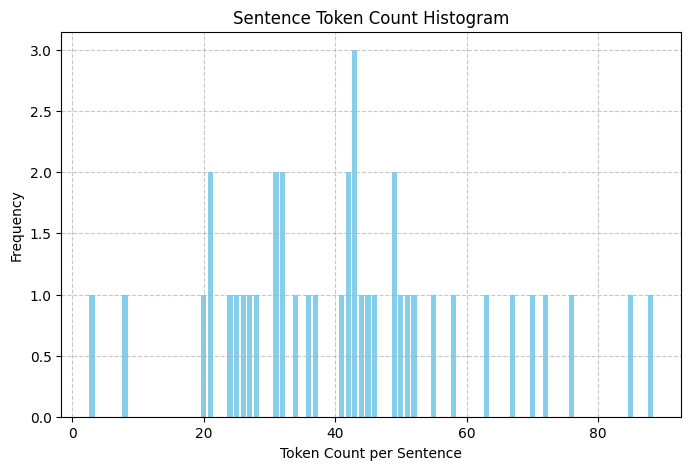

{24: 1,
 20: 1,
 46: 1,
 44: 1,
 72: 1,
 21: 2,
 49: 2,
 8: 1,
 43: 3,
 25: 1,
 3: 1,
 41: 1,
 52: 1,
 42: 2,
 26: 1,
 36: 1,
 31: 2,
 85: 1,
 27: 1,
 88: 1,
 50: 1,
 45: 1,
 37: 1,
 55: 1,
 63: 1,
 28: 1,
 32: 2,
 34: 1,
 51: 1,
 70: 1,
 58: 1,
 76: 1,
 67: 1}

In [19]:
text_test = extract_pdf_with_placeholders(pdf_path, metadata_path)
calculate_token_histogram(tokenizer, text_test)  # lets just check how many tokens have sentences on average. It will be helpful to adjust max_tokens

### Inference of model

In [27]:
def split_text_into_chunks(tokenizer, text, max_tokens=250):
    """Split text into chunks without splitting sentences, ensuring each chunk fits max token size."""
    sentences = text.split('. ')
    chunks, current_chunk = [], ""
    for sentence in sentences:
        temp_chunk = current_chunk + sentence + ". "
        if len(tokenizer(temp_chunk, return_tensors="pt").input_ids[0]) <= max_tokens:
            current_chunk = temp_chunk
        else:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = sentence + ". "
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

In [31]:
#text = "Tak więc MoE łączy kilka innych modeli, aby wybrać, który ślad (część modelu) powinna zostać użyta do uzyskania prawidłowej odpowiedzi."
text = extract_pdf_with_placeholders(pdf_path, metadata_path)
chunks = split_text_into_chunks(tokenizer, text)

In [32]:
text

'Oryginalny skrypt wykorzystuje metodę A3C z biblioteki deepchem. W implementacji tej brakuje zwracanych metryk oraz progresu trenowania. W uczeniu przez wzmocnienie, skuteczna optymalizacja jest trudna bez szczegółowej analizy wydajności w miarę progresu uczenia. Aby to osiągnąć, monitoruje się szereg metryk, z których każda zapewnia wgląd w różne aspekty zachowania agenta. Metryki zaimplementowane w moich skryptach, obejmują kilka kluczowych wskaźników procesu uczenia się: skumulowane nagrody, średnie nagrody, zdyskontowane nagrody, entropię i długości epizodów. Wskaźniki te, często analizowane w wygładzonej (ang. Smoothed) formie, zapewniają kompleksowy obraz wydajności agenta, kompromisów między eksploracją a eksploatacją oraz wydajności treningu. Wygładzanie (ang. Smoothing) wykorzystuje średnią ruchomą, czyli każdy punkt danych jest zastępowany średnią sąsiednich punktów. Ilość punktów liczonych do tych średnich jest wyznaczana przez tzw. okno. Technika ta redukuje szumy i krótko

In [33]:
def translate_text(model, tokenizer, chunks, source_lang="Polish", target_lang="English"):
    """Translate text chunks and extract only content after [/INST] with proper regex handling."""
    output = []
    for chunk in tqdm(chunks, desc="Generating progress"):
        chat_style_prompt = [{"role": "user", "content": f"Translate this from {source_lang} to {target_lang}:\n{source_lang}:\n{chunk}\n{target_lang}:"}]
        prompt = tokenizer.apply_chat_template(chat_style_prompt, tokenize=False, add_generation_prompt=True)
        input_ids = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                num_beams=3,  # Lowered beams for faster inference. TODO: check 5
                max_new_tokens=2048,  # Extended output length to 2048 tokens wich is maximum possible
                do_sample=True,
                temperature=0.6,  # Slightly higher temperature for more creative results. TODO: try lower (would be better for translation)
                top_p=0.9  # Slightly wider nucleus sampling for diversity. TODO: check other values
            )
            result = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            
            # Enhanced regex to capture content after [/INST]
            match = re.search(r'\\?\[/INST\\?\](.*)', result, re.DOTALL)
            translated_text = match.group(1).strip() if match else result.strip()
            output.append(translated_text)
    
    return " ".join(output)

In [34]:
output = translate_text(model, tokenizer, chunks, source_lang="Polish", target_lang="English")

Generating progress: 100%|██████████| 8/8 [03:45<00:00, 28.25s/it]


In [35]:
output

"The original script uses the A3C method from the deepchem library. This implementation lacks returned metrics and progress tracking. In reinforcement learning, effective optimization is difficult without a detailed analysis of performance over time. To achieve this, various metrics are monitored, each providing insight into different aspects of the agent's behavior. The metrics implemented in my scripts include several key indicators of the learning process: cumulative rewards, average rewards, discounted rewards, entropy, and episode lengths. These metrics, often analyzed in smoothed form, provide a comprehensive view of the agent's performance. In smoothed form, it provides a comprehensive picture of agent performance, trade-offs between exploration and exploitation, and training efficiency. Smoothing uses a moving average, where each data point is replaced by the average of its neighboring points. The number of points counted for these averages is determined by the so-called window